In [1]:
import functools
import json
import os
from typing import Any, List, Tuple, Union
import einops
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn.functional as F
from fancy_einsum import einsum
from sklearn.linear_model import LinearRegression
from torch import nn
from toy_transformer import ParenTransformer, SimpleTokenizer

MAIN = __name__ == "__main__"
device = "cuda"
IS_CI = os.getenv("IS_CI")

In [2]:
model = ParenTransformer(ntoken=5, nclasses=2, d_model=56, nhead=2, d_hid=56, nlayers=3).to(device)
state_dict = t.load("w2d3_state_dict.pt")
model.to(device)
model.load_simple_transformer_state_dict(state_dict)
model.eval()
tokenizer = SimpleTokenizer("()")
with open("w2d3_data.json") as f:
    data_tuples: List[Tuple[str, bool]] = json.load(f)
    print(f"loaded {len(data_tuples)} examples")
assert isinstance(data_tuples, list)


class DataSet:
    """A dataset containing sequences, is_balanced labels, and tokenized sequences"""

    def __init__(self, data_tuples: list):
        """
        data_tuples is List[Tuple[str, bool]] signifying sequence and label
        """
        self.strs = [x[0] for x in data_tuples]
        self.isbal = t.tensor([x[1] for x in data_tuples]).to(device=device, dtype=t.bool)
        self.toks = tokenizer.tokenize(self.strs).to(device)

        self.open_proportion = t.tensor([s.count("(") / len(s) for s in self.strs])
        self.starts_open = t.tensor([s[0] == "(" for s in self.strs]).bool()

    def __len__(self) -> int:
        return len(self.strs)

    def __getitem__(self, idx) -> Union["DataSet", tuple[str, t.Tensor, t.Tensor]]:
        if type(idx) == slice:
            return self.__class__(list(zip(self.strs[idx], self.isbal[idx])))
        return self.strs[idx], self.isbal[idx], self.toks[idx]

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(cls, data_tuples: list[tuple[str, bool]], selected_len: int) -> "DataSet":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(cls, data_tuples: list[tuple[str, bool]], start_char: str) -> "DataSet":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])


# N_SAMPLES = 5000 if not IS_CI else 100
data_tuples = data_tuples
data = DataSet(data_tuples)

loaded 100000 examples


In [3]:
print(t.argmax(model(data.toks), dim=-1))
print(data.isbal)

tensor([0, 0, 1,  ..., 0, 0, 1], device='cuda:0')
tensor([False, False,  True,  ..., False, False,  True], device='cuda:0')


In [4]:
correct = t.argmax(model(data.toks), dim=-1) == data.isbal
print(t.sum(correct)/len(correct))

tensor(0.9999, device='cuda:0')


In [5]:
def run_model_on_data(model: ParenTransformer, data: DataSet, batch_size: int = 2000) -> t.Tensor:
    """Return probability that each example is balanced"""
    ln_probs = []
    for i in range(0, len(data.strs), batch_size):
        toks = data.toks[i : i + batch_size]
        # note model outputs in a weird shape, [seqlen, batch, 2 (unbal, bal)]
        with t.no_grad():
            out = model(toks)
        ln_probs.append(out)
    out = t.cat(ln_probs).exp()
    assert out.shape == (len(data), 2)
    return out

def get_inputs(model: ParenTransformer, data: DataSet, module: nn.Module) -> t.Tensor:
    """
    Get the inputs to a particular submodule of the model when run on the data.
    Returns a tensor of size (data_pts, seq_pos, emb_size).
    """
    "SOLUTION"
    acts = []
    fn = lambda m, i, o: acts.append(i[0].detach().clone())
    h = module.register_forward_hook(fn)
    run_model_on_data(model, data)
    h.remove()
    out = t.concat(acts, dim=0)
    assert out.shape == (len(data), data.seq_length, model.d_model)
    return out.clone()


def get_outputs(model: ParenTransformer, data: DataSet, module: nn.Module) -> t.Tensor:
    """
    Get the outputs from a particular submodule of the model when run on the data.
    Returns a tensor of size (data_pts, seq_pos, emb_size).
    """
    "SOLUTION"
    acts = []
    fn = lambda m, i, o: acts.append(o.detach().clone())
    h = module.register_forward_hook(fn)
    run_model_on_data(model, data)
    h.remove()
    out = t.concat(acts, dim=0)
    assert out.shape == (len(data), data.seq_length, model.d_model)
    return out.clone()

def get_out_by_head(model: ParenTransformer, data: DataSet, layer: int) -> t.Tensor:
    """
    Get the output of the heads in a particular layer when the model is run on the data.
    Returns a tensor of shape (batch, num_heads, seq, embed_width)
    """

    "SOLUTION"
    out_proj: nn.Linear = model.layers[layer].self_attn.project_output
    combined_values = get_inputs(model, data, out_proj).to(device)
    num_heads = model.nhead
    # pytorch stores weight matricies in shape [out_features, in_features]
    o_mats_by_head = einops.rearrange(out_proj.weight, " out (head head_size) -> out head head_size", head=num_heads)
    head_value = einops.rearrange(combined_values, "b seq (head head_size)-> b seq head head_size", head=num_heads)
    out_by_head = einsum(
        "out head head_size, batch seq head head_size -> batch head seq out",
        o_mats_by_head,
        head_value,
    )
    assert out_by_head.shape == (len(data), num_heads, data.seq_length, model.d_model)
    return out_by_head.clone()

In [6]:
with t.inference_mode():
    head_all = get_out_by_head(model, data, 0).cpu().numpy()

head = head_all[:, 0, 1]

In [92]:
is_left = t.sum(data.toks == 3, dim=1)
is_right = t.sum(data.toks == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

In [93]:
print(equal_num.shape)
print(head.shape)

(100000,)
(100000, 56)


In [97]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

head_train, head_test, equal_num_train, equal_num_test = train_test_split(head, equal_num, test_size=0.1)

linear = Ridge(alpha=0.1)
fitted_linear = linear.fit(head_train, equal_num_train)
print("LINEAR TRAIN SCORE: ", fitted_linear.score(head_train, equal_num_train))
print("LINEAR TEST SCORE: ", fitted_linear.score(head_test, equal_num_test))

logistic = LogisticRegression()
fitted_logistic = logistic.fit(head, equal_num > 0)
print("LOGISTIC TRAIN SCORE: ", fitted_logistic.score(head_train, equal_num_train > 0))
print("LOGISTIC TEST SCORE: ", fitted_logistic.score(head_test, equal_num_test > 0))

LINEAR TRAIN SCORE:  0.9433968252058565
LINEAR TEST SCORE:  0.9446982943055677
LOGISTIC TRAIN SCORE:  0.9493777777777778
LOGISTIC TEST SCORE:  0.9514


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1]:
import numpy as np

index = 0

is_left = t.sum(data.toks[index:] == 3, dim=1)
is_right = t.sum(data.toks[index:] == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])
dot_scores = np.dot(head_all[:, 0, index], paren_emb[:, None])[:, 0]
plt.scatter(dot_scores, equal_num)

NameError: name 't' is not defined

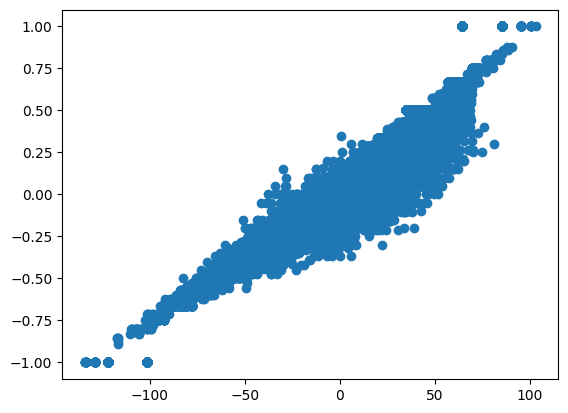

In [108]:
import numpy as np

paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])
dot_scores = np.dot(head, paren_emb[:, None])[:, 0]
plt.scatter(dot_scores, equal_num)

In [99]:
print(list(fitted_linear.coef_))
print(fitted_linear.intercept_)

[0.6957917, 0.59944093, -1.0147251, 3.8021724, -3.5778842, 1.6739573, -0.29665315, 0.6043825, -0.7319515, 0.72144914, -1.5906075, -0.7782403, 0.43377784, 0.93158233, -2.5924559, -0.962626, -1.0297241, 0.13413242, -0.8444396, 0.31689143, 0.9103052, -0.52191836, -1.4871575, -0.26765567, 2.1903932, 0.354667, 1.0537567, -1.5249196, 1.5180318, -0.12691274, -0.35784832, 1.7299594, -0.5756264, -3.8590117, -0.53154993, -0.025224507, 0.9939769, -0.8150835, -1.1005669, -0.5077586, -0.16486959, -0.42760968, -1.444979, 0.33551675, -1.440161, 0.67834026, 0.20499009, 0.83807296, 1.8270139, -1.2330928, 0.9159838, -0.1344012, 2.529079, 0.8573505, 0.4836902, -0.32683372]
-1.4240535


In [91]:
print(fitted_linear.coef_)
print(fitted_linear.intercept_)

[ 203.89867    -85.39272    198.81613    -70.11029   -185.94077
 -371.7755     241.11273   -116.778885    89.805435     8.642548
  -99.72683    113.35329    325.12143   -234.48303     38.77481
  348.44952    336.28815    -79.82727   -342.4427      51.81051
 -216.90881   -372.40344   -202.81696    338.92065    -16.24034
  159.88925    -91.38898     22.917664   138.89667   -163.70291
   68.135056   304.10608    132.2829    -106.853935   -31.945587
 -109.22226    -27.928917   -20.00038     61.088947  -171.24222
 -146.82693    -21.021461   297.66013   -264.2655    -250.93457
  411.97977     63.968277   146.41164    -39.349426   141.69286
   -3.2745552 -106.78399    118.69666   -255.423      -81.99983
  201.02673  ]
3.4669752


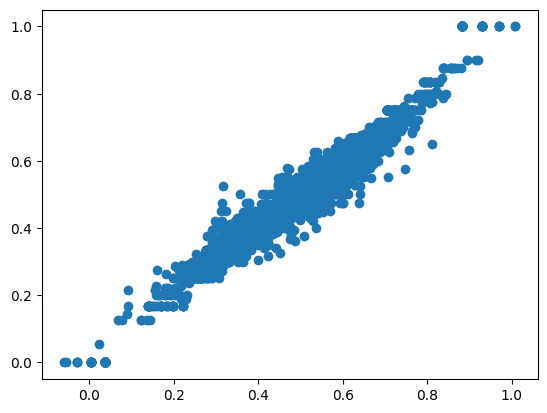

In [88]:
plt.scatter(fitted_linear.predict(head_test), equal_num_test)

In [59]:
fitted_lr.predict(head.cpu())

array([ 2.906311  ,  1.7578735 , -0.5648804 , ..., -2.9223022 ,
        1.4907837 , -0.49017334], dtype=float32)

In [31]:
cache = None

def cache_fn(module, input, out):
    global cache
    cache = out.detach()

hooks = []
# for i, layer in enumerate(model.layers):
#     if i == 0
hooks.append(model.layers[0].self_attn.register_forward_hook(cache_fn))

with t.inference_mode():
    model(data.toks)

for hook in hooks:
    hook.remove()

In [34]:
print(model.layers[0])

TransformerBlock(
  (norm1): LayerNorm((56,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((56,), eps=1e-05, elementwise_affine=True)
  (self_attn): BertSelfAttention(
    (project_query): Linear(in_features=56, out_features=56, bias=True)
    (project_key): Linear(in_features=56, out_features=56, bias=True)
    (project_value): Linear(in_features=56, out_features=56, bias=True)
    (project_output): Linear(in_features=56, out_features=56, bias=True)
  )
  (linear1): Linear(in_features=56, out_features=56, bias=True)
  (linear2): Linear(in_features=56, out_features=56, bias=True)
  (activation): ReLU()
)


In [33]:
print(cache.shape)

torch.Size([100000, 42, 56])


In [25]:
for hook in hooks:
    hook.remove()